Some info about this notebook:
- Currently using resnet20 or resnet32 for cifar10, if you want to use other network, feel free to change it in the `train` function as that's where downloading the dataset is
- `depth` hyperparam in `general_hyperparameters` will allow toggle between resnet20 or 32
- Currently using `MultiStepLR` as learning rate scheduler
- Feel free to go through the `train` function as change as you see fit to add Apollo in!

In [1]:
from __future__ import print_function
import logging
import os
import sys
# sys.path.append("C:\\Users\\Tuan Tran\\Desktop\\CS595_final\\adahessian\\image_classification")

import numpy as np
import argparse
from tqdm import tqdm, tqdm_notebook, trange

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets, transforms
from torch.autograd import Variable

from optim.adahessian_helpers.utils import *
from optim.adahessian_helpers.models.resnet import *
from optim.adahessian_helpers.optim_adahessian import Adahessian
from optim import Apollo
import matplotlib.pyplot as plt
import time

In [2]:
"""
Function to initialize optimizers, download data, lr scheduler then training loop and checkpoint best model
"""
def train(dataset_name,
          optimizer_str,
          lr,
          lr_decay,
          lr_decay_epoch,
          weight_decay,
          batch_size,
          test_batch_size,
          epochs,
          depth,
          seed):

    # set random seed to reproduce the work
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # Create dir for checkpoint best model per optimizer
    if not os.path.isdir('checkpoint/'):
        os.makedirs('checkpoint/')
    
    print(f"Retrieving {dataset_name}")
    # get dataset
    train_loader, test_loader = getData(
        name=dataset_name, train_bs=batch_size, test_bs=test_batch_size)

    # make sure to use cudnn.benchmark for second backprop
    cudnn.benchmark = True

    # get model and optimizer
    model = resnet(num_classes=10, depth=depth).cuda()
    model = torch.nn.DataParallel(model)
    #print('    Total params: %.2fM' % (sum(p.numel()
    #                                       for p in model.parameters()) / 1000000.0))

    criterion = nn.CrossEntropyLoss()
    if optimizer_str == 'sgd':
        optimizer = optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=0.9,
            weight_decay=weight_decay)
    elif optimizer_str == 'adam':
        optimizer = optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay)
    elif optimizer_str == 'adamw':
        print('For AdamW, we automatically correct the weight decay term for you! If this is not what you want, please modify the code!')
        weight_decay = weight_decay / lr
        optimizer = optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay)
    elif optimizer_str == 'adahessian':
        print('For AdaHessian, we use the decoupled weight decay as AdamW. Here we automatically correct this for you! If this is not what you want, please modify the code!')
        weight_decay = weight_decay / lr
        optimizer = Adahessian(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay)
    elif optimizer_str == "apollo":
        weight_decay = weight_decay / lr 
        optimizer = Apollo(
            model.parameters(),
            lr = lr,
            weight_decay = weight_decay,
            init_lr = lr / 5)
    else:
        raise Exception('We do not support this optimizer yet!!')

    # learning rate schedule
    scheduler = lr_scheduler.MultiStepLR(
        optimizer,
        lr_decay_epoch,
        gamma=lr_decay,
        last_epoch=-1)

    # Start training loop
    best_acc = 0.0
    losses_list = []
    acc_list = []
    
    for epoch in range(1, epochs + 1):
        print('Current Epoch: ', epoch)
        train_loss = 0.
        total_num = 0
        correct = 0

        scheduler.step()
        model.train()
        with tqdm_notebook(total=len(train_loader.dataset)) as progressbar:
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                output = model(data)
                loss = criterion(output, target)
                loss.backward(create_graph=True)
                train_loss += loss.item() * target.size()[0]
                total_num += target.size()[0]
                _, predicted = output.max(1)
                correct += predicted.eq(target).sum().item()
                optimizer.step()
                optimizer.zero_grad()
                progressbar.update(target.size(0))

        acc = test(model, test_loader)
        train_loss /= total_num
        #print(f"Training Loss of Epoch {epoch}: {np.around(train_loss, 2)}")
        #print(f"Testing of Epoch {epoch}: {np.around(acc * 100, 2)}")
        losses_list.append(train_loss)
        acc_list.append(acc)
        
        if acc > best_acc:
            # Only display if found new best model
            print(f"Training Loss of Epoch {epoch}: {np.around(train_loss, 2)}")
            print(f"Testing of Epoch {epoch}: {np.around(acc * 100, 2)}")
            best_acc = acc
            torch.save({
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'best_accuracy': best_acc,
                }, f'checkpoint/{optimizer_str}_netbest.pkl')
    
    print(f'Best Acc for {optimizer_str} with dataset {dataset_name}: {np.around(best_acc * 100, 2)}')
    losses_plot_string = ("%s_%s_loss_plot.jpg" % (optimizer_str, dataset_name))
    accuracy_plot_string = ("%s_%s_accuracy_plot.jpg" % (optimizer_str, dataset_name))
    #losses plot
    loss_fig = plt.figure() 
    plt.plot(losses_list)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    loss_fig.suptitle("%s" % (optimizer_str.upper()))
    plt.show()
    loss_fig.savefig(losses_plot_string)
    #accuracy plot
    acc_fig = plt.figure()
    plt.plot(acc_list)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    acc_fig.suptitle("%s" % (optimizer_str.upper()))
    plt.show()
    acc_fig.savefig(accuracy_plot_string)

APOLLO
Retrieving cifar10
Files already downloaded and verified
Current Epoch:  1


/home/life/.local/lib/python3.6/site-packages/ipykernel_launcher.py:94: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training Loss of Epoch 1: 1.78
Testing of Epoch 1: 38.89
Current Epoch:  2



Training Loss of Epoch 2: 1.28
Testing of Epoch 2: 44.97
Current Epoch:  3



Training Loss of Epoch 3: 1.01
Testing of Epoch 3: 55.71
Current Epoch:  4



Training Loss of Epoch 4: 0.86
Testing of Epoch 4: 70.22
Current Epoch:  5



Current Epoch:  6



Current Epoch:  7



Training Loss of Epoch 7: 0.63
Testing of Epoch 7: 74.39
Current Epoch:  8



Current Epoch:  9



Current Epoch:  10



Current Epoch:  11



Current Epoch:  12



Training Loss of Epoch 12: 0.49
Testing of Epoch 12: 80.32
Current Epoch:  13



Current Epoch:  14



Current Epoch:  15



Current Epoch:  16



Current Epoch:  17



Training Loss of Epoch 17: 0.43
Testing of Epoch 17: 81.79
Current Epoch:  18



Current Epoch:  19



Current Epoch:  20



Current Epoch:  21



Current Epoch:  22



Current Epoch:  23



Current Epoch:  24



Current Epoch:  25



Training Loss of Epoch 25: 0.38
Testing of Epoch 25: 82.43
Current Epoch:  26



Current Epoch:  27



Current Epoch:  28



Current Epoch:  29



Current Epoch:  30



Current Epoch:  31



Training Loss of Epoch 31: 0.35
Testing of Epoch 31: 83.89
Current Epoch:  32



Training Loss of Epoch 32: 0.35
Testing of Epoch 32: 84.14
Current Epoch:  33



Current Epoch:  34



Current Epoch:  35



Training Loss of Epoch 35: 0.33
Testing of Epoch 35: 84.51
Current Epoch:  36



Current Epoch:  37



Current Epoch:  38



Current Epoch:  39



Current Epoch:  40



Current Epoch:  41



Current Epoch:  42



Current Epoch:  43



Current Epoch:  44



Current Epoch:  45



Current Epoch:  46



Current Epoch:  47



Current Epoch:  48



Current Epoch:  49



Current Epoch:  50



Current Epoch:  51



Current Epoch:  52



Current Epoch:  53



Current Epoch:  54



Current Epoch:  55



Current Epoch:  56



Training Loss of Epoch 56: 0.29
Testing of Epoch 56: 84.8
Current Epoch:  57



Current Epoch:  58



Current Epoch:  59



Current Epoch:  60



Current Epoch:  61



Current Epoch:  62



Current Epoch:  63



Current Epoch:  64



Current Epoch:  65



Current Epoch:  66



Training Loss of Epoch 66: 0.28
Testing of Epoch 66: 86.78
Current Epoch:  67



Current Epoch:  68



Current Epoch:  69



Current Epoch:  70



Current Epoch:  71



Current Epoch:  72



Current Epoch:  73



Current Epoch:  74



Current Epoch:  75



Current Epoch:  76



Current Epoch:  77



Current Epoch:  78



Current Epoch:  79



Current Epoch:  80



Training Loss of Epoch 80: 0.17
Testing of Epoch 80: 91.74
Current Epoch:  81



Training Loss of Epoch 81: 0.14
Testing of Epoch 81: 91.98
Current Epoch:  82



Training Loss of Epoch 82: 0.12
Testing of Epoch 82: 92.15
Current Epoch:  83



Training Loss of Epoch 83: 0.11
Testing of Epoch 83: 92.24
Current Epoch:  84



Training Loss of Epoch 84: 0.11
Testing of Epoch 84: 92.29
Current Epoch:  85



Current Epoch:  86



Training Loss of Epoch 86: 0.09
Testing of Epoch 86: 92.5
Current Epoch:  87



Current Epoch:  88



Current Epoch:  89



Current Epoch:  90



Current Epoch:  91



Current Epoch:  92



Current Epoch:  93



Current Epoch:  94



Current Epoch:  95



Current Epoch:  96



Current Epoch:  97



Current Epoch:  98



Current Epoch:  99



Current Epoch:  100



Current Epoch:  101



Current Epoch:  102



Current Epoch:  103



Current Epoch:  104



Current Epoch:  105



Current Epoch:  106



Current Epoch:  107



Current Epoch:  108



Current Epoch:  109



Current Epoch:  110



Current Epoch:  111



Current Epoch:  112



Current Epoch:  113



Current Epoch:  114



Current Epoch:  115



Current Epoch:  116



Current Epoch:  117



Current Epoch:  118



Current Epoch:  119



Current Epoch:  120



Training Loss of Epoch 120: 0.03
Testing of Epoch 120: 92.61
Current Epoch:  121



Current Epoch:  122



Current Epoch:  123



Training Loss of Epoch 123: 0.02
Testing of Epoch 123: 92.67
Current Epoch:  124



Training Loss of Epoch 124: 0.02
Testing of Epoch 124: 92.81
Current Epoch:  125



Current Epoch:  126



Current Epoch:  127



Current Epoch:  128



Current Epoch:  129



Current Epoch:  130



Current Epoch:  131



Current Epoch:  132



Training Loss of Epoch 132: 0.02
Testing of Epoch 132: 92.84
Current Epoch:  133



Current Epoch:  134



Current Epoch:  135



Training Loss of Epoch 135: 0.02
Testing of Epoch 135: 92.87
Current Epoch:  136



Current Epoch:  137



Current Epoch:  138



Training Loss of Epoch 138: 0.02
Testing of Epoch 138: 92.88
Current Epoch:  139



Current Epoch:  140



Current Epoch:  141



Current Epoch:  142



Current Epoch:  143



Current Epoch:  144



Current Epoch:  145



Current Epoch:  146



Current Epoch:  147



Current Epoch:  148



Current Epoch:  149



Current Epoch:  150



Current Epoch:  151



Current Epoch:  152



Current Epoch:  153



Current Epoch:  154



Current Epoch:  155



Current Epoch:  156



Current Epoch:  157



Current Epoch:  158



Current Epoch:  159



Current Epoch:  160



Best Acc for apollo with dataset cifar10: 92.88


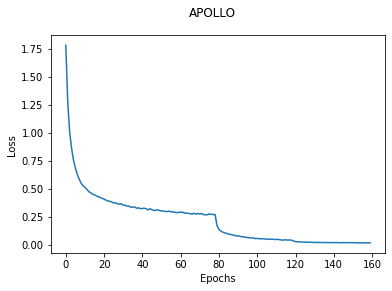

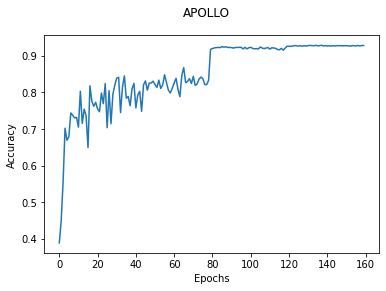

ADAHESSIAN
Retrieving cifar10
Files already downloaded and verified
For AdaHessian, we use the decoupled weight decay as AdamW. Here we automatically correct this for you! If this is not what you want, please modify the code!
Current Epoch:  1



Training Loss of Epoch 1: 1.93
Testing of Epoch 1: 41.64
Current Epoch:  2



Training Loss of Epoch 2: 1.31
Testing of Epoch 2: 53.95
Current Epoch:  3



Training Loss of Epoch 3: 1.08
Testing of Epoch 3: 55.5
Current Epoch:  4



Training Loss of Epoch 4: 0.93
Testing of Epoch 4: 62.92
Current Epoch:  5



Training Loss of Epoch 5: 0.82
Testing of Epoch 5: 72.14
Current Epoch:  6



Current Epoch:  7



Current Epoch:  8



Current Epoch:  9



Current Epoch:  10



Training Loss of Epoch 10: 0.56
Testing of Epoch 10: 74.02
Current Epoch:  11



Current Epoch:  12



Training Loss of Epoch 12: 0.51
Testing of Epoch 12: 79.51
Current Epoch:  13



Current Epoch:  14



Current Epoch:  15



Current Epoch:  16



Current Epoch:  17



Current Epoch:  18



Current Epoch:  19



Current Epoch:  20



Current Epoch:  21



Current Epoch:  22



Current Epoch:  23



Training Loss of Epoch 23: 0.41
Testing of Epoch 23: 80.42
Current Epoch:  24



Current Epoch:  25



Current Epoch:  26



Current Epoch:  27



Training Loss of Epoch 27: 0.39
Testing of Epoch 27: 82.18
Current Epoch:  28



Current Epoch:  29



Current Epoch:  30



Current Epoch:  31



Current Epoch:  32



Training Loss of Epoch 32: 0.37
Testing of Epoch 32: 83.48
Current Epoch:  33



Current Epoch:  34



Current Epoch:  35



Current Epoch:  36



Current Epoch:  37



Current Epoch:  38



Current Epoch:  39



Current Epoch:  40



Current Epoch:  41



Current Epoch:  42



Current Epoch:  43



Current Epoch:  44



Current Epoch:  45



Current Epoch:  46



Current Epoch:  47



Current Epoch:  48



Current Epoch:  49



Current Epoch:  50



Current Epoch:  51



Training Loss of Epoch 51: 0.34
Testing of Epoch 51: 83.94
Current Epoch:  52



Current Epoch:  53



Current Epoch:  54



Training Loss of Epoch 54: 0.33
Testing of Epoch 54: 84.45
Current Epoch:  55



Current Epoch:  56



Current Epoch:  57



Current Epoch:  58



Current Epoch:  59



Current Epoch:  60



Current Epoch:  61



Current Epoch:  62



Current Epoch:  63



Current Epoch:  64



Current Epoch:  65



Current Epoch:  66



Training Loss of Epoch 66: 0.32
Testing of Epoch 66: 84.83
Current Epoch:  67



Current Epoch:  68



Current Epoch:  69



Current Epoch:  70



Current Epoch:  71



Current Epoch:  72



Current Epoch:  73



Current Epoch:  74



Current Epoch:  75



Current Epoch:  76



Current Epoch:  77



Training Loss of Epoch 77: 0.31
Testing of Epoch 77: 84.93
Current Epoch:  78



Current Epoch:  79



Current Epoch:  80



Training Loss of Epoch 80: 0.2
Testing of Epoch 80: 91.26
Current Epoch:  81



Training Loss of Epoch 81: 0.16
Testing of Epoch 81: 91.5
Current Epoch:  82



Training Loss of Epoch 82: 0.14
Testing of Epoch 82: 91.57
Current Epoch:  83



Training Loss of Epoch 83: 0.13
Testing of Epoch 83: 91.95
Current Epoch:  84



Training Loss of Epoch 84: 0.12
Testing of Epoch 84: 92.18
Current Epoch:  85



Current Epoch:  86



Current Epoch:  87



Current Epoch:  88



Current Epoch:  89



Current Epoch:  90



Current Epoch:  91



Current Epoch:  92



Current Epoch:  93



Current Epoch:  94



Current Epoch:  95



Current Epoch:  96



Current Epoch:  97



Current Epoch:  98



Current Epoch:  99



Training Loss of Epoch 99: 0.07
Testing of Epoch 99: 92.33
Current Epoch:  100



Current Epoch:  101



Current Epoch:  102



Current Epoch:  103



Current Epoch:  104



Current Epoch:  105



Current Epoch:  106



Current Epoch:  107



Current Epoch:  108



Current Epoch:  109



Current Epoch:  110



Current Epoch:  111



Current Epoch:  112



Current Epoch:  113



Current Epoch:  114



Current Epoch:  115



Current Epoch:  116



Current Epoch:  117



Current Epoch:  118



Current Epoch:  119



Current Epoch:  120



Current Epoch:  121



Current Epoch:  122



Current Epoch:  123



Current Epoch:  124



Current Epoch:  125



Current Epoch:  126



Current Epoch:  127



Current Epoch:  128



Current Epoch:  129



Current Epoch:  130



Current Epoch:  131



Current Epoch:  132



Training Loss of Epoch 132: 0.03
Testing of Epoch 132: 92.4
Current Epoch:  133



Current Epoch:  134



Current Epoch:  135



Current Epoch:  136



Current Epoch:  137



Current Epoch:  138



Current Epoch:  139



Current Epoch:  140



Current Epoch:  141



Current Epoch:  142



Current Epoch:  143



Current Epoch:  144



Current Epoch:  145



Current Epoch:  146



Current Epoch:  147



Current Epoch:  148



Current Epoch:  149



Current Epoch:  150



Current Epoch:  151



Current Epoch:  152



Current Epoch:  153



Current Epoch:  154



Current Epoch:  155



Current Epoch:  156



Current Epoch:  157



Current Epoch:  158



Current Epoch:  159



Current Epoch:  160



Best Acc for adahessian with dataset cifar10: 92.4


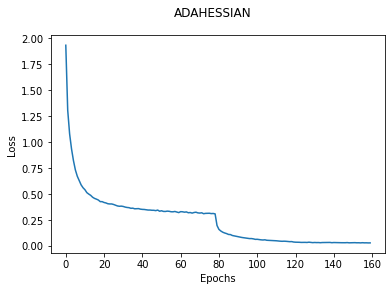

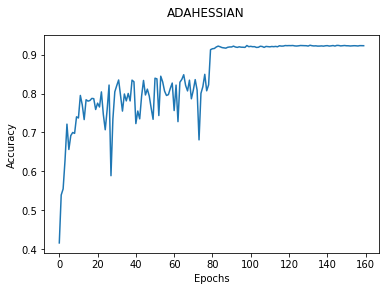

ADAM
Retrieving cifar10
Files already downloaded and verified
Current Epoch:  1



Training Loss of Epoch 1: 1.62
Testing of Epoch 1: 48.44
Current Epoch:  2



Training Loss of Epoch 2: 1.19
Testing of Epoch 2: 57.91
Current Epoch:  3



Training Loss of Epoch 3: 0.99
Testing of Epoch 3: 66.57
Current Epoch:  4



Current Epoch:  5



Training Loss of Epoch 5: 0.78
Testing of Epoch 5: 68.18
Current Epoch:  6



Training Loss of Epoch 6: 0.71
Testing of Epoch 6: 71.42
Current Epoch:  7



Current Epoch:  8



Training Loss of Epoch 8: 0.61
Testing of Epoch 8: 76.55
Current Epoch:  9



Training Loss of Epoch 9: 0.59
Testing of Epoch 9: 77.48
Current Epoch:  10



Current Epoch:  11



Current Epoch:  12



Training Loss of Epoch 12: 0.51
Testing of Epoch 12: 81.46
Current Epoch:  13



Current Epoch:  14



Current Epoch:  15



Current Epoch:  16



Current Epoch:  17



Current Epoch:  18



Current Epoch:  19



Training Loss of Epoch 19: 0.41
Testing of Epoch 19: 82.82
Current Epoch:  20



Current Epoch:  21



Current Epoch:  22



Current Epoch:  23



Current Epoch:  24



Current Epoch:  25



Training Loss of Epoch 25: 0.35
Testing of Epoch 25: 84.06
Current Epoch:  26



Current Epoch:  27



Current Epoch:  28



Current Epoch:  29



Current Epoch:  30



Training Loss of Epoch 30: 0.32
Testing of Epoch 30: 85.24
Current Epoch:  31



Current Epoch:  32



Current Epoch:  33



Training Loss of Epoch 33: 0.3
Testing of Epoch 33: 85.25
Current Epoch:  34



Current Epoch:  35



Training Loss of Epoch 35: 0.29
Testing of Epoch 35: 85.43
Current Epoch:  36



Current Epoch:  37



Current Epoch:  38



Current Epoch:  39



Training Loss of Epoch 39: 0.28
Testing of Epoch 39: 86.74
Current Epoch:  40



Current Epoch:  41



Current Epoch:  42



Current Epoch:  43



Current Epoch:  44



Current Epoch:  45



Current Epoch:  46



Current Epoch:  47



Current Epoch:  48



Current Epoch:  49



Current Epoch:  50



Current Epoch:  51



Current Epoch:  52



Current Epoch:  53



Current Epoch:  54



Current Epoch:  55



Training Loss of Epoch 55: 0.24
Testing of Epoch 55: 87.42
Current Epoch:  56



Current Epoch:  57



Current Epoch:  58



Current Epoch:  59



Current Epoch:  60



Current Epoch:  61



Current Epoch:  62



Current Epoch:  63



Current Epoch:  64



Current Epoch:  65



Current Epoch:  66



Current Epoch:  67



Current Epoch:  68



Current Epoch:  69



Current Epoch:  70



Current Epoch:  71



Training Loss of Epoch 71: 0.21
Testing of Epoch 71: 88.02
Current Epoch:  72



Current Epoch:  73



Training Loss of Epoch 73: 0.21
Testing of Epoch 73: 88.25
Current Epoch:  74



Current Epoch:  75



Current Epoch:  76



Current Epoch:  77



Current Epoch:  78



Current Epoch:  79



Current Epoch:  80



Training Loss of Epoch 80: 0.14
Testing of Epoch 80: 90.86
Current Epoch:  81



Training Loss of Epoch 81: 0.11
Testing of Epoch 81: 91.02
Current Epoch:  82



Current Epoch:  83



Current Epoch:  84



Training Loss of Epoch 84: 0.08
Testing of Epoch 84: 91.13
Current Epoch:  85



Current Epoch:  86



Current Epoch:  87



Current Epoch:  88



Current Epoch:  89



Training Loss of Epoch 89: 0.07
Testing of Epoch 89: 91.15
Current Epoch:  90



Current Epoch:  91



Current Epoch:  92



Current Epoch:  93



Current Epoch:  94



Current Epoch:  95



Training Loss of Epoch 95: 0.05
Testing of Epoch 95: 91.28
Current Epoch:  96



Current Epoch:  97



Current Epoch:  98



Current Epoch:  99



Current Epoch:  100



Current Epoch:  101



Current Epoch:  102



Current Epoch:  103



Current Epoch:  104



Current Epoch:  105



Current Epoch:  106



Current Epoch:  107



Current Epoch:  108



Current Epoch:  109



Current Epoch:  110



Current Epoch:  111



Current Epoch:  112



Current Epoch:  113



Current Epoch:  114



Current Epoch:  115



Current Epoch:  116



Current Epoch:  117



Current Epoch:  118



Current Epoch:  119



Current Epoch:  120



Current Epoch:  121



Current Epoch:  122



Current Epoch:  123



Current Epoch:  124



Current Epoch:  125



Current Epoch:  126



Current Epoch:  127



Training Loss of Epoch 127: 0.02
Testing of Epoch 127: 91.34
Current Epoch:  128



Current Epoch:  129



Current Epoch:  130



Current Epoch:  131



Current Epoch:  132



Current Epoch:  133



Current Epoch:  134



Current Epoch:  135



Current Epoch:  136



Current Epoch:  137



Current Epoch:  138



Current Epoch:  139



Current Epoch:  140



Current Epoch:  141



Current Epoch:  142



Current Epoch:  143



Current Epoch:  144



Current Epoch:  145



Current Epoch:  146



Current Epoch:  147



Current Epoch:  148



Current Epoch:  149



Current Epoch:  150



Current Epoch:  151



Current Epoch:  152



Current Epoch:  153



Current Epoch:  154



Current Epoch:  155



Current Epoch:  156



Current Epoch:  157



Current Epoch:  158



Current Epoch:  159



Current Epoch:  160



Best Acc for adam with dataset cifar10: 91.34


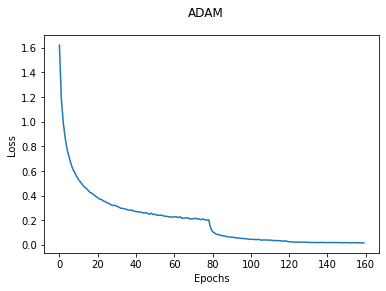

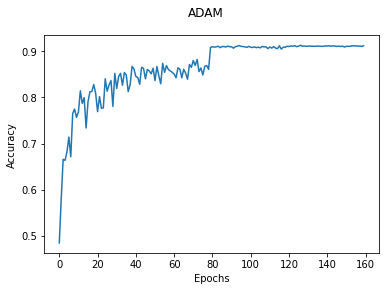

ADAMW
Retrieving cifar10
Files already downloaded and verified
For AdamW, we automatically correct the weight decay term for you! If this is not what you want, please modify the code!
Current Epoch:  1



Training Loss of Epoch 1: 1.73
Testing of Epoch 1: 39.32
Current Epoch:  2



Training Loss of Epoch 2: 1.27
Testing of Epoch 2: 56.15
Current Epoch:  3



Training Loss of Epoch 3: 1.01
Testing of Epoch 3: 65.18
Current Epoch:  4



Training Loss of Epoch 4: 0.86
Testing of Epoch 4: 68.04
Current Epoch:  5



Current Epoch:  6



Training Loss of Epoch 6: 0.67
Testing of Epoch 6: 75.5
Current Epoch:  7



Current Epoch:  8



Current Epoch:  9



Current Epoch:  10



Current Epoch:  11



Current Epoch:  12



Current Epoch:  13



Current Epoch:  14



Training Loss of Epoch 14: 0.46
Testing of Epoch 14: 77.0
Current Epoch:  15



Training Loss of Epoch 15: 0.45
Testing of Epoch 15: 80.39
Current Epoch:  16



Current Epoch:  17



Current Epoch:  18



Current Epoch:  19



Current Epoch:  20



Current Epoch:  21



Current Epoch:  22



Current Epoch:  23



Training Loss of Epoch 23: 0.39
Testing of Epoch 23: 82.12
Current Epoch:  24



Training Loss of Epoch 24: 0.39
Testing of Epoch 24: 82.8
Current Epoch:  25



Current Epoch:  26



Current Epoch:  27



Current Epoch:  28



Current Epoch:  29



Current Epoch:  30



Current Epoch:  31



Current Epoch:  32



Current Epoch:  33



Current Epoch:  34



Current Epoch:  35



Current Epoch:  36



Current Epoch:  37



Current Epoch:  38



Current Epoch:  39



Current Epoch:  40



Current Epoch:  41



Current Epoch:  42



Current Epoch:  43



Current Epoch:  44



Training Loss of Epoch 44: 0.34
Testing of Epoch 44: 83.9
Current Epoch:  45



Current Epoch:  46



Current Epoch:  47



Current Epoch:  48



Current Epoch:  49



Current Epoch:  50



Current Epoch:  51



Current Epoch:  52



Current Epoch:  53



Current Epoch:  54



Current Epoch:  55



Training Loss of Epoch 55: 0.32
Testing of Epoch 55: 84.38
Current Epoch:  56



Training Loss of Epoch 56: 0.32
Testing of Epoch 56: 84.57
Current Epoch:  57



Current Epoch:  58



Current Epoch:  59



Current Epoch:  60



Current Epoch:  61



Current Epoch:  62



Current Epoch:  63



Current Epoch:  64



Current Epoch:  65



Current Epoch:  66



Current Epoch:  67



Current Epoch:  68



Current Epoch:  69



Current Epoch:  70



Current Epoch:  71



Current Epoch:  72



Current Epoch:  73



Current Epoch:  74



Current Epoch:  75



Current Epoch:  76



Current Epoch:  77



Current Epoch:  78



Training Loss of Epoch 78: 0.31
Testing of Epoch 78: 84.6
Current Epoch:  79



Current Epoch:  80



Training Loss of Epoch 80: 0.19
Testing of Epoch 80: 91.06
Current Epoch:  81



Training Loss of Epoch 81: 0.15
Testing of Epoch 81: 91.66
Current Epoch:  82



Current Epoch:  83



Current Epoch:  84



Training Loss of Epoch 84: 0.12
Testing of Epoch 84: 91.77
Current Epoch:  85



Current Epoch:  86



Training Loss of Epoch 86: 0.1
Testing of Epoch 86: 91.83
Current Epoch:  87



Training Loss of Epoch 87: 0.1
Testing of Epoch 87: 91.86
Current Epoch:  88



Training Loss of Epoch 88: 0.09
Testing of Epoch 88: 92.16
Current Epoch:  89



Current Epoch:  90



Current Epoch:  91



Current Epoch:  92



Current Epoch:  93



Current Epoch:  94



Current Epoch:  95



Current Epoch:  96



Current Epoch:  97



Current Epoch:  98



Current Epoch:  99



Current Epoch:  100



Current Epoch:  101



Current Epoch:  102



Current Epoch:  103



Current Epoch:  104



Current Epoch:  105



Current Epoch:  106



Current Epoch:  107



Current Epoch:  108



Current Epoch:  109



Current Epoch:  110



Current Epoch:  111



Current Epoch:  112



Training Loss of Epoch 112: 0.04
Testing of Epoch 112: 92.25
Current Epoch:  113



Current Epoch:  114



Current Epoch:  115



Current Epoch:  116



Current Epoch:  117



Current Epoch:  118



Current Epoch:  119



Current Epoch:  120



Training Loss of Epoch 120: 0.03
Testing of Epoch 120: 92.29
Current Epoch:  121



Training Loss of Epoch 121: 0.02
Testing of Epoch 121: 92.38
Current Epoch:  122



Current Epoch:  123



Training Loss of Epoch 123: 0.02
Testing of Epoch 123: 92.5
Current Epoch:  124



Current Epoch:  125



Current Epoch:  126



Training Loss of Epoch 126: 0.02
Testing of Epoch 126: 92.66
Current Epoch:  127



Current Epoch:  128



Current Epoch:  129



Current Epoch:  130



Training Loss of Epoch 130: 0.02
Testing of Epoch 130: 92.73
Current Epoch:  131



Current Epoch:  132



Current Epoch:  133



Current Epoch:  134



Current Epoch:  135



Current Epoch:  136



Training Loss of Epoch 136: 0.01
Testing of Epoch 136: 92.76
Current Epoch:  137



Current Epoch:  138



Current Epoch:  139



Current Epoch:  140



Training Loss of Epoch 140: 0.01
Testing of Epoch 140: 92.83
Current Epoch:  141



Current Epoch:  142



Current Epoch:  143



Current Epoch:  144



Current Epoch:  145



Current Epoch:  146



Current Epoch:  147



Current Epoch:  148



Current Epoch:  149



Current Epoch:  150



Current Epoch:  151



Current Epoch:  152



Current Epoch:  153



Current Epoch:  154



Current Epoch:  155



Current Epoch:  156



Current Epoch:  157



Current Epoch:  158



Current Epoch:  159



Current Epoch:  160



Best Acc for adamw with dataset cifar10: 92.83


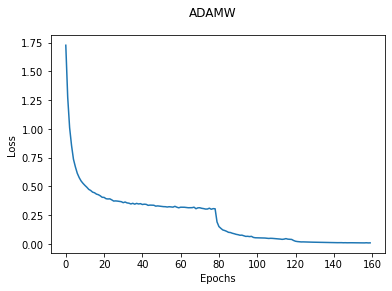

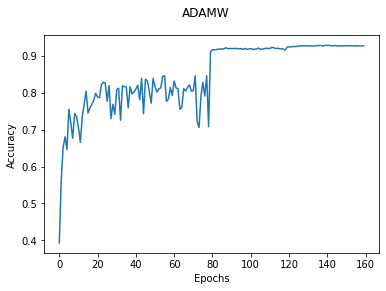

In [4]:
"""
Training settings
"""
# Specific hyperparams for each optimizer
optim_to_params = {
    "sgd": {
        "lr": 0.1,
        'lr_decay': 0.1,
        'lr_decay_epoch': [80, 120],
        'weight_decay': 5e-4
    },
    "adam": {
        "lr": 0.001,
        'lr_decay': 0.1,
        'lr_decay_epoch': [80, 120],
        'weight_decay': 5e-4
    },
    "adamw": {
        "lr": 0.01,
        'lr_decay': 0.1,
        'lr_decay_epoch': [80, 120],
        'weight_decay': 5e-4
    },
    "adahessian": {
        "lr": 0.15,
        'lr_decay': 0.1,
        'lr_decay_epoch': [80, 120],
        'weight_decay': 5e-4
    },
    "apollo": {
        "lr": 0.375,
        'lr_decay': 0.1,
        'lr_decay_epoch': [80, 120],
        'weight_decay': 5e-4
    }    
}

# General hyperparameters that apply to all optimizers, feel free to change this around as you see fit
general_hyperparams = {
    'batch_size': 256,
    'test_batch_size': 256,
    'epochs': 160,
    # Depth of ResNet, 20 = resnet20, 32 = resnet32
    'depth': 32,
    'seed': 1
}

# cifar10 or mnist
dataset_names = ["cifar10"]

optimizers = ['apollo', 'adahessian', 'adam', 'adamw']
# Run the loop to train using each optimizer in the list of optimizers
for dataset_name in dataset_names:
    for optimizer_str in optimizers:
        print(f"{optimizer_str.upper()}")
        optim_hyperparams = optim_to_params[optimizer_str]
        train(dataset_name, optimizer_str, **optim_hyperparams, **general_hyperparams)